<a href="https://colab.research.google.com/github/HrithikNambiar/Missing-value-Estimation-in-Gene-Microarray/blob/main/Missing_value_Estimation_in_Gene_Microarray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Missing value estimation methods for DNA microarrays**



> **Hrithik Nambiar (2019A7PS0100G)** | **Shreyas Hebbar S (2020A7PS1003G)** | **Arnav Mishra (2020AAPS1237G)**



**Honour code: I shall be honest in my efforts and will make my parents proud.**
```
# Signature: Hrithik Nambiar, Arnav Mishra, Shreyas Hebbar S
Date: 05/12/2022
```

This is the code for the final project for BITS F464: Machine Learning. We have implemented all aspects of the paper "Missing value estimation methods for DNA microarrays".

Reference:


> [1] Troyanskaya, O., Cantor, M., Sherlock, G., Brown, P., Hastie, T., Tibshirani, R., Botstein, D. and Altman, R.B., 2001. Missing value estimation methods for DNA microarrays. Bioinformatics, 17(6), pp.520-525. 

Repo link - https://github.com/HrithikNambiar/Missing-value-Estimation-in-Gene-Microarray




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cd '/content/drive/MyDrive/Missing value estimation'

In [ ]:
#imports 

import pandas as pd
import numpy as np
import math
import random
import copy
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer 

## Library 

Here we have listed out all the functions we have utilized below

In [ ]:
def corrupt(df: pd.DataFrame, percentage):
  arr = np.array(df) # A 2D array
  selection_list = list(range(0, arr.shape[0]*arr.shape[1]))
  for i in range(0, int(arr.shape[0]*arr.shape[1]*(percentage*100))//100):
    indx = random.choice(selection_list)
    selection_list.remove(indx)
    arr[indx//arr.shape[1], indx%arr.shape[1]] = np.NaN 
  l1 = np.argwhere(np.isnan(arr))
  return arr, l1;

# KNN impute -  without using library

# def distance(i, j, array: np.array):
#   temp = array[i, :] - array[j, :]
#   weight = (temp.size - 1)/(np.argwhere(~np.isnan(temp)).size)
#   temp = temp[~np.isnan(temp)]
#   sum = np.nansum(temp.T@temp)
#   rms = math.sqrt(weight*sum)
#   return rms

# def knn_impute(df: pd.DataFrame, percentage, k):
#   array, l1 = corrupt(df, percentage) #l1 is the list of indices which have NaN values
#   for x in l1:
#     l2 = [] #used to store the distances 
#     neighbours = [] #used to store the indices of the nearest neighbours
#     for y in range(0 ,array.shape[0]):
#       l2.append(distance(x[0], y, array))
#     l2 = np.array(l2)
#     for z in range(0, k):
#       neighbours.append(np.argmax(l2))
#       l2[neighbours[-1]] = 0;
#     mean = 0
#     for z in neighbours:
#       mean += array[z, x[1]]
#     array[x[0], x[1]] = mean/k
#   return array

def knn_impute_lib(df, percentage, k):
  """
  using the sklearn library - we noticed this was faster than our implementation above.
  """
  original = np.array(df)
  corrupted, index = corrupt(df, percentage)
  imputer = KNNImputer(n_neighbors=k)
  knn_imp_data = imputer.fit_transform(corrupted)
  return knn_imp_data, corrupted, original, index

# row average
def row_avg_impute(df, percentage):
  original = np.array(df)
  corrupted, index = corrupt(df, percentage)
  imputed = np.copy(corrupted)
  means = np.nanmean(corrupted, axis = 0)
  for i in index:
    imputed[i[0]][i[1]] = means[i[1]]
  return imputed, corrupted, original, index

# SVD

# normalized rmse
def norm_rmse(imputed_data: np.array, data: np.array):
  """
  We tried multiple ways to normalize. However the rmse wouldn't be between 0-1 as mentioned in the paper. 
  The normalization method is not clearly defined in the method. As mentioned in the paper, we divied by the average of all data entries (np.mean()).
  However for all three datasets , the mean is very low (-.08 for spellman). Leading to larger rmse values.
  Finally, we have used the mean to find rmse as in paper, graphs follow in the notebook.
  """
  error = 0
  sum = 0
  normal = 1
  # normal = np.mean(data)
  for i in range(0,len(imputed_data)):
    for j in range(0,len(imputed_data[0])):
      error+= ((imputed_data[i][j] - data[i][j])/normal)**2
  norm_error = error**(0.5) # paper says average value, but since small number, norm rmse willbe a large number
  return norm_error

## Dataset 1: Spellman [ time series, not noisy ]

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Missing value estimation/2010.Spellman98_cdc15.flt.knn.avg.pcl', delimiter = '\t')
df.drop([0], axis = 0, inplace = True) #dropping eweight
df.drop(["YORF", "GWEIGHT", "NAME"], axis = 1, inplace = True) #dropping yorf, name and gweight
df.head()

,cdc 15 010 min; src: asynchronous<->010 min,cdc15 030 min; src: asynchronous<->030 min,cdc15 050 min; src: asynchronous<->050 min,cdc15 070 min; src: asynchronous<->070 min,cdc15 080 min; src: Asynchronous<->80 minutes,cdc15 090 min; src: asynchronous<->090 min,cdc15 100 min; src: asynchronous<->100 min,cdc15 110 min; src: asynchronous<->110 min,cdc15 120 min; src: asynchronous<->120 min,cdc15 130 min; src: asynchronous<->130 min,...,cdc15 180 min; src: asynchronous<->180 min,cdc15 190 min; src: asynchronous<->190 min,cdc15 200 min; src: asynchronous<->200 min,cdc15 210 min; src: asynchronous<->210 min,cdc15 220 min; src: Asynchromous<->220 minutes,cdc15 230 min; src: asynchronous<->230 min,cdc15 240 min; src: asynchronous<->240 min,cdc15 250 min; src: asynchronous<->250 min,cdc15 270 min; src: asynchronous<->270 min,cdc15 290 min; src: Asynchronous Control<->290 min
1,0.921,0.979,1.189,0.802,0.263,0.6680,0.414,0.5820,0.851,0.823,...,-0.0980,0.331,0.021,0.440,-0.101,0.9310,0.134,0.661,0.744,0.6150
2,0.807,0.459,-0.140,0.211,0.087,0.0770,-0.095,0.2460,-0.355,0.198,...,-0.3580,0.032,-0.052,0.198,-0.866,-0.6790,-1.210,-0.430,-0.750,-0.7940
3,-0.737,0.082,-0.039,-0.381,-0.017,-0.1560,-0.867,-0.4850,-1.040,-0.514,...,0.9160,-0.176,0.329,0.036,0.156,1.1060,0.164,-0.600,-0.868,-0.1810
4,-0.948,-0.013,0.042,-2.322,-0.221,-1.5500,0.402,-1.7370,0.198,-2.678,...,0.9400,-0.585,-1.318,0.322,0.462,0.3150,0.363,-0.520,-1.308,-0.9770
5,-0.495,0.141,-2.092,-0.590,-0.010,-0.4135,-2.209,-0.3065,-0.029,-1.355,...,-0.8915,-0.278,-1.897,0.175,0.246,0.2305,-0.763,-0.397,0.112,-1.1035


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5754 entries, 1 to 5754
Data columns (total 25 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   cdc 15 010 min; src: asynchronous<->010 min         5754 non-null   float64
 1   cdc15 030 min; src: asynchronous<->030 min          5754 non-null   float64
 2   cdc15 050 min; src: asynchronous<->050 min          5754 non-null   float64
 3   cdc15 070 min; src: asynchronous<->070 min          5754 non-null   float64
 4   cdc15 080 min; src: Asynchronous<->80 minutes       5754 non-null   float64
 5   cdc15 090 min; src: asynchronous<->090 min          5754 non-null   float64
 6   cdc15 100 min; src: asynchronous<->100 min          5754 non-null   float64
 7   cdc15 110 min; src: asynchronous<->110 min          5754 non-null   float64
 8   cdc15 120 min; src: asynchronous<->120 min          5754 non-null   float64
 9

## Corruption based on percentage &  Metric - RMSE

In [ ]:
#function that removes X% of values from the dataset
def corrupt(df, percentage):
  arr = np.array(df)
  selection_list = list(range(0, arr.shape[0]*arr.shape[1]))
  for i in range(0, int(arr.shape[0]*arr.shape[1]*(percentage*100))//100):
    indx = random.choice(selection_list)
    selection_list.remove(indx)
    arr[indx//arr.shape[1], indx%arr.shape[1]] = np.NaN
  l1 = np.argwhere(np.isnan(arr))
  return arr, l1

# arr is the np array with missing values(NaN) and l1 is the list of the indices with missing value  
a1, a2 = corrupt(df, .05)
print(a1.shape)
print(a2.shape)
print("The corrupted data {}".format(a1))
print("The corrupt index {}".format(a2))

(5754, 25)
(7192, 2)
The corrupted data [[ 0.921  0.979  1.189 ...  0.661  0.744  0.615]
 [ 0.807  0.459 -0.14  ... -0.43  -0.75  -0.794]
 [-0.737  0.082 -0.039 ... -0.6      nan -0.181]
 ...
 [ 0.193  0.021  0.14  ... -0.648 -0.426 -0.205]
 [-0.411  0.39   0.456 ... -0.235 -0.339    nan]
 [ 1.336  1.415  0.928 ...  0.122 -0.247  0.002]]
The corrupt index [[   0   11]
 [   1   13]
 [   1   14]
 ...
 [5750   16]
 [5752   10]
 [5752   24]]


In [ ]:
#error
def norm_rmse(imputed_data: np.array, data: np.array):
  error = 0
  sum = 0
  mean = np.mean(data)
  for i in range(0,len(imputed_data)):
    for j in range(0,len(imputed_data[0])):
      error+= ((imputed_data[i][j] - data[i][j]))**2
  norm_error = (error)**(0.5) # paper says average value, but since small number, norm rmse willbe a large number
  return norm_error

## KNN Imputatation

In [ ]:
#KNN

def distance(i, j, array):
  temp = array[i, :] - array[j, :]
  weight = (temp.size - 1)/(np.argwhere(~np.isnan(temp)).size)
  temp = temp[~np.isnan(temp)]
  sum = np.nansum(temp.T@temp)
  rms = math.sqrt(weight*sum)
  return rms

def knn_impute(df, percentage, k):
  array, l1 = corrupt(df, percentage) #l1 is the list of indices which have NaN values
  for x in l1:
    l2 = [] #used to store the distances 
    neighbours = [] #used to store the indices of the nearest neighbours
    for y in range(0 ,array.shape[0]):
      l2.append(distance(x[0], y, array))
    l2 = np.array(l2)
    for z in range(0, k):
      neighbours.append(np.argmax(l2))
      l2[neighbours[-1]] = 0;
    mean = 0
    for z in neighbours:
      mean += array[z, x[1]]
    array[x[0], x[1]] = mean/k
  return array

# def knn_impute_lib(df, percentage, k):
#   corrupted, index = corrupt(df, percentage)
#   imputer = KNNImputer(n_neighbors=k)
#   knn_imp_data = imputer.fit_transform(corrupted)
#   return knn_imp_data, corrupted, index


The rmse for 1 neighbours is 24.31755156589576
The rmse for 3 neighbours is 22.804577010328426
The rmse for 5 neighbours is 19.89071142709581
The rmse for 12 neighbours is 19.584090396203404
The rmse for 17 neighbours is 21.259682635133775
The rmse for 23 neighbours is 19.115563431030406
The rmse for 92 neighbours is 21.10804940043662
The rmse for 458 neighbours is 21.995929659809377
The rmse for 916 neighbours is 22.290123737370667
The rmse for 1 neighbours is 54.68697015880473
The rmse for 3 neighbours is 47.28744445156661
The rmse for 5 neighbours is 47.002940152998946
The rmse for 12 neighbours is 44.43056206761155
The rmse for 17 neighbours is 46.31868014866524
The rmse for 23 neighbours is 44.99101667906349
The rmse for 92 neighbours is 46.63141975259324
The rmse for 458 neighbours is 48.92678395035754
The rmse for 916 neighbours is 50.933330867131055
The rmse for 1 neighbours is 79.4648219626144
The rmse for 3 neighbours is 69.55274292083024
The rmse for 5 neighbours is 64.05523

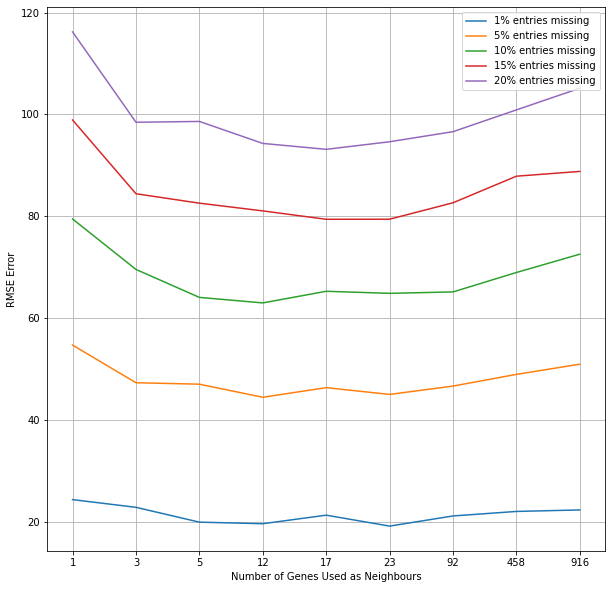

In [ ]:
# KNN - effect of neighbours
plt.figure(figsize = (10, 10))
plt.grid()
plt.xlabel("Number of Genes Used as Neighbours")
plt.ylabel("RMSE Error")
l1 = [.01, .05, .1, .15, .2]
for i in l1:
  knn_error = []
  for k in [1,3,5,12,17,23,92,458,916]:
    imputed, cor, original, ind = knn_impute_lib(df, i, k)
    error = norm_rmse(imputed, original)
    knn_error.append(error)
    print("The rmse for {} neighbours is {}".format(k,error))
  plt.plot(['1','3','5','12','17','23','92','458','916'], knn_error) #x axis use [1,3,5,12,17,23,92,458,916]!!

plt.legend(["1% entries missing", "5% entries missing", "10% entries missing", "15% entries missing", "20% entries missing"], loc = "upper right")

In [ ]:
# knn best result for k =12 as seen above
# we check the effect of different corruption levels
l1 = [.01, .05, .1, .15, .2]
knn_error = []
for i in l1:
  imputed, cor, original, ind = knn_impute_lib(df, i, 12)
  error = norm_rmse(imputed, original)
  knn_error.append(error)
knn_error

[21.73446475430465,
 44.76559206580358,
 63.606186277995796,
 82.02006866944012,
 93.9173429275148]

## Row Average

In [ ]:
# row average
def row_avg_impute(df, percentage):
  original = np.array(df)
  corrupted, index = corrupt(df, percentage)
  imputed = np.copy(corrupted)
  means = np.nanmean(corrupted, axis = 0)
  for i in index:
    imputed[i[0]][i[1]] = means[i[1]]
  return imputed, corrupted, original, index

In [ ]:
#row average - spellman for different corruption percentage
l1 = [.01, .05, .1, .15, .2]
ravg_error = []
for i in l1:
  imp1, cor1, ori1, ind1 = row_avg_impute(df,i)
  ravg_error.append(norm_rmse(imp1,ori1))
ravg_error

[27.548315014964054,
 58.88465712629803,
 85.08198348212319,
 103.6151752469333,
 120.24071515959976]

## SVD Imputation

In [ ]:
def svdimpute(df, percentage_corrupt, threshold=0.01, max_steps=100, frac=0.2):
    # set the missing indices as 0 to generate complete matrices -> change this to row average
    array, indices = corrupt(df, percentage_corrupt)
    mean = np.mean(array, 0)
    for i in indices:
        array[i[0]][i[1]]= mean[i[1]]
    
    error=np.inf
    iters=0
    original= np.array(df)
    for iters in range(max_steps):
        if(error<=threshold):
            print("Threshold reached")
            break
        u,s,vh = np.linalg.svd(array)
        genes=int(len(vh)*frac)
        # the gene, where missing value index removed. To be regressed
        for i in indices:
            ind=[]
            for j in range(len(array[i[0]])):
                if([i[0],j] not in indices):
                    ind.append(j)
            x=[]
            for j in ind:
                x.append(array[i[0]][j])
            vh_temp=[]
            for j in vh:
                temp=list(j)
                temp2=[]
                for k in ind:
                    temp2.append(temp[k])
                vh_temp.append(temp2)
            vh_temp=vh_temp[:genes]
            
            #regression to find coef
            vh_temp=np.array(vh_temp)
            x=np.array(x)
            # solving Ax=b using lstsq
            coeff=np.linalg.lstsq(vh_temp.T,x,rcond=None)[0]

            #Set the missing value to the newly calculated one
            array[i[0]][i[1]]=sum([coeff[j]*vh[j][i[1]] for j in range(len(coeff))])
        iters+=1
        if(iters>5):
            #error calculation
            error = norm_rmse(array,original)**0.5
            
        #Update old matrix to current one
        original=copy.deepcopy(array)    
                
                
    return array

svdimpute(df, .01, 0.01, 100, 0.2)

Threshold reached


array([[ 0.921,  0.979,  1.189, ...,  0.661,  0.744,  0.615],
       [ 0.807,  0.459, -0.14 , ..., -0.43 , -0.75 , -0.794],
       [-0.737,  0.082, -0.039, ..., -0.6  , -0.868, -0.181],
       ...,
       [ 0.193,  0.021,  0.14 , ...,  0.   , -0.426, -0.205],
       [-0.411,  0.39 ,  0.456, ..., -0.235, -0.339, -0.326],
       [ 1.336,  1.415,  0.928, ...,  0.122, -0.247,  0.002]])

In [ ]:
plt.figure(figsize = (10, 10))
plt.grid()
plt.xlabel("Number of eigengenes selected")
plt.ylabel("RMSE Error")
l1 = [.01, .05, .1, .15, .2]
for i in l1:
  knn_error = []
  for k in [.05, .10 ,.15, .20]:
    imputed = svdimpute(df, i , threshold=0.01, max_steps=100, frac= k)
    error = norm_rmse(imputed, np.array(df))
    knn_error.append(error)
    print("The rmse for {} neighbours is {}".format(k,error))
  plt.plot(np.arange(1,5), knn_error) 

plt.legend(["5% eigen vectors", "10% eigen vectors", "15% eigen vectors", "20% eigen vectors"], loc = "upper right")

## Dataset 2: Di Risi [noisy time series]

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Missing value estimation/DeRisi/2010.diauxic.pcl', delimiter = '\t')
df.drop([0], axis = 0, inplace = True) #dropping eweight
df.drop(["YORF", "NAME", "GWEIGHT"], axis = 1, inplace = True) #dropping yorf, name and gweight
df.head()

,0 hr,9.5 hr,11.5 hr,13.5 hr,15.5 hr,18.5 hr,20.5 hr
1,-0.01,0.29,-0.42,-0.29,-0.07,0.04,0.06
2,0.00,0.19,0.12,-0.36,0.06,0.11,-0.15
3,0.06,0.03,0.07,-0.34,-0.03,0.08,-0.07
4,0.15,0.00,0.11,-0.23,0.03,0.01,-0.03
5,0.30,0.07,0.19,-0.23,-0.09,0.04,-0.10


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6034 entries, 1 to 6034
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   0 hr     6032 non-null   float64
 1   9.5 hr   6004 non-null   float64
 2   11.5 hr  5971 non-null   float64
 3   13.5 hr  6023 non-null   float64
 4   15.5 hr  6008 non-null   float64
 5   18.5 hr  6034 non-null   float64
 6   20.5 hr  5972 non-null   float64
dtypes: float64(7)
memory usage: 377.1 KB


The rmse for 1 neighbours is 9.387150792439638
The rmse for 3 neighbours is 6.744003921179825
The rmse for 5 neighbours is 6.275551927918374
The rmse for 12 neighbours is 6.39557507621915
The rmse for 17 neighbours is 7.00295325739502
The rmse for 23 neighbours is 5.744542211298591
The rmse for 92 neighbours is 6.0025186339051135
The rmse for 458 neighbours is 7.461977593221718
The rmse for 916 neighbours is 7.373482383181805
The rmse for 1 neighbours is 20.59125785375922
The rmse for 3 neighbours is 17.25804611059884
The rmse for 5 neighbours is 17.148975479602306
The rmse for 12 neighbours is 16.020088864367217
The rmse for 17 neighbours is 15.520718110237015
The rmse for 23 neighbours is 16.003390000040117
The rmse for 92 neighbours is 15.401514126658695
The rmse for 458 neighbours is 16.64326699758068
The rmse for 916 neighbours is 18.191972508947554
The rmse for 1 neighbours is 36.98812782501985
The rmse for 3 neighbours is 29.506246607945467
The rmse for 5 neighbours is 27.049029

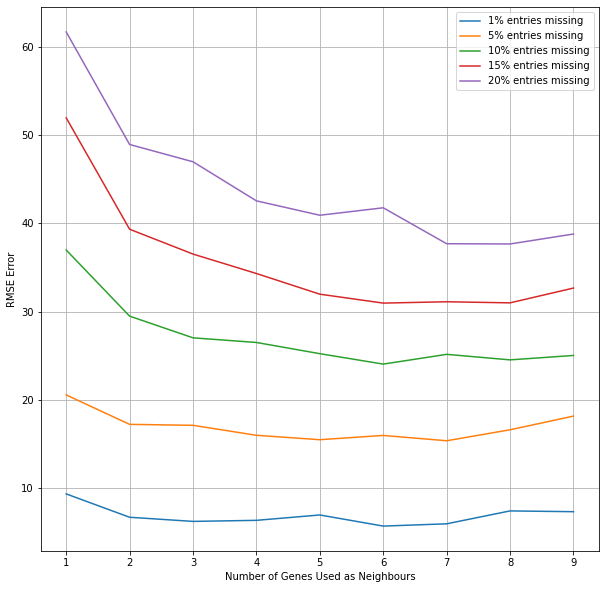

In [ ]:
# KNN - effect of neighbours
plt.figure(figsize = (10, 10))
plt.grid()
plt.xlabel("Number of Genes Used as Neighbours")
plt.ylabel("RMSE Error")
l1 = [.01, .05, .1, .15, .2]
for i in l1:
  knn_error = []
  for k in [1,3,5,12,17,23,92,458,916]:
    imputed, cor, original, ind = knn_impute_lib(df, i, k)
    error = norm_rmse(imputed, original)
    knn_error.append(error)
    print("The rmse for {} neighbours is {}".format(k,error))
  plt.plot(np.arange(1,10), knn_error) #x axis use [1,3,5,12,17,23,92,458,916]!!

plt.legend(["1% entries missing", "5% entries missing", "10% entries missing", "15% entries missing", "20% entries missing"], loc = "upper right")

In [ ]:
l1 = [.01, .05, .1, .15, .2]
knn_error = []
for i in l1:
  imputed, cor, original, ind = knn_impute_lib(df, i, 12)
  error = norm_rmse(imputed, original)
  knn_error.append(error)

In [ ]:
knn_error

[7.843338070192649,
 16.194399988027428,
 25.742264655296605,
 34.51683625018705,
 42.33416199976357]

## Dataset 3: Gasch [ non time series]


## Graphs of results from 3 datasets

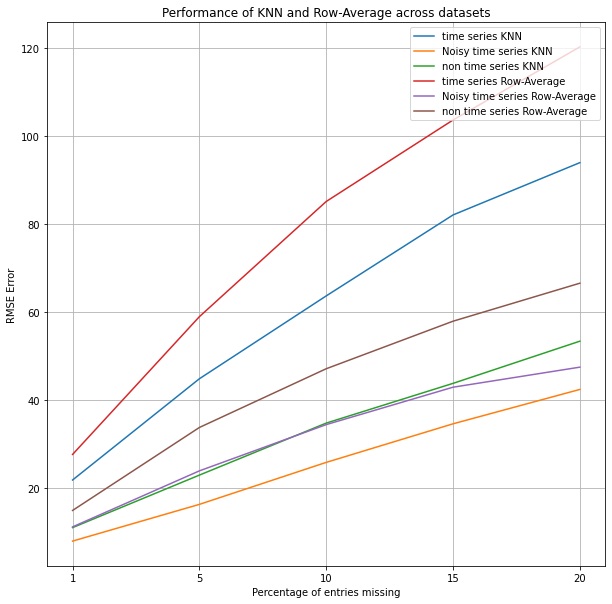

In [ ]:
plt.figure(figsize = (10, 10))
plt.grid()
plt.title('Performance of KNN and Row-Average across datasets')
plt.xlabel("Percentage of entries missing")
plt.ylabel("RMSE Error")
plt.plot(['1', '5', '10', '15', '20'], [21.73446475430465, 44.76559206580358, 63.606186277995796, 82.02006866944012, 93.9173429275148]) #spellman 
plt.plot(['1', '5', '10', '15', '20'], [7.843338070192649,16.194399988027428,25.742264655296605,34.51683625018705,42.33416199976357]) # derisi
plt.plot(['1', '5', '10', '15', '20'], [10.907567995665648, 22.850439363152226, 34.67735231916203, 43.71711254820508, 53.31002895031229]) #gasch

plt.plot(['1', '5', '10', '15', '20'], [27.548315014964054,58.88465712629803,85.08198348212319,103.6151752469333,120.24071515959976]) #spellman 
plt.plot(['1', '5', '10', '15', '20'], [11.076206544432488,23.81513730864908,34.33421123876832,42.842336072013964, 47.40399341170714]) # derisi
plt.plot(['1', '5', '10', '15', '20'], [14.810754997882576, 33.683613522902895, 47.04072688484223, 57.85431749206883, 66.49777736456444]) #gasch

plt.legend(["time series KNN", "Noisy time series KNN", "non time series KNN", "time series Row-Average", "Noisy time series Row-Average", "non time series Row-Average"], loc = "upper right")